# Getting started with the Qiskit-Braket provider

### Qiskit to Braket mapping

![qiskit-to-braket-diagram](./data/qiskit-braket-mapping.png)

We first start by importing all required classes and functions for this notebook. We also start the cost tracker to print the costs at the end of this notebook.

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit.visualization import plot_histogram

from braket.tracking import Tracker

from qiskit_braket_provider import BraketLocalBackend, BraketProvider, to_braket

# Use Braket SDK Cost Tracking to estimate the cost to run this example
t = Tracker().start()

### Access Braket devices from Qiskit 

`BraketProvider` class gives you a method `backends` to access backends that are available through Braket SDK.

Let's get available devices to use by Qiskit

In [2]:
provider = BraketProvider()
print(provider.backends())

[BraketBackend[Aria 1], BraketBackend[Aria 2], BraketBackend[Aspen-M-3], BraketBackend[Forte 1], BraketBackend[Harmony], BraketBackend[Lucy], BraketBackend[SV1], BraketBackend[TN1], BraketBackend[dm1]]


If you want to explore what is available by specific contraints, you can specify query arguments to `backends` method of provider.
Arguments are fully compatible with Braket's `get_device` method. See the documentation at [braket.aws.aws_device.AwsDevice.get_devices](https://amazon-braket-sdk-python.readthedocs.io/en/stable/_apidoc/braket.aws.aws_device.html#braket.aws.aws_device.AwsDevice.get_devices). For example, you can retrieve the list of online simulators via:

In [3]:
online_simulators_backends = provider.backends(statuses=["ONLINE"], types=["SIMULATOR"])
online_simulators_backends

[BraketBackend[SV1], BraketBackend[TN1], BraketBackend[dm1]]

For prototyping it is usually a good practice to use simulators 
to set up workflow of your program and then change it to real device.
We can access local simulator by creating instance of class `BraketLocalBackend`

In [4]:
local_simulator = BraketLocalBackend()
local_simulator

BraketBackend[default]

Any backend can be instantiated via the `get_backend` method of the provider. Here is an example where we create a Backend object for the IonQ `Aria 1` device.

In [5]:
Aria_1 = provider.get_backend("Aria 1")

### Running circuits on Braket devices

Let's first create Qiskit circuit. We will start with a Bell circuit.

In [6]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

This circuit can be used to submit a task to the local simulator. In the [tutorials](https://github.com/qiskit-community/qiskit-braket-provider/tree/main/docs/tutorials) associated to the Qiskit-Braket provider, we will use the Braket taxonomy:
- a task is an atomic request to a device or a simulator. 
- an hybrid job is a mean to run hybrid quantum-classical algorithms requiring both classical AWS resources and quantum processing units (QPUs). See [What is a Hybrid Job](https://docs.aws.amazon.com/braket/latest/developerguide/braket-what-is-hybrid-job.html) for more details.

Here, quantum tasks are analogous to Qiskit jobs, which is why tasks have a `job_id` property. If a task has been submitted to Braket managed device, `job_id` will return a Task ARN (Amazon Resource number) which identifies the task and allows to retrieve it in the Braket Console and in your notebooks. 

In [7]:
task = local_simulator.run(qc, shots=10)

Results are returned via a `Result` object, from which you can extract counts and plot them in a histogram.

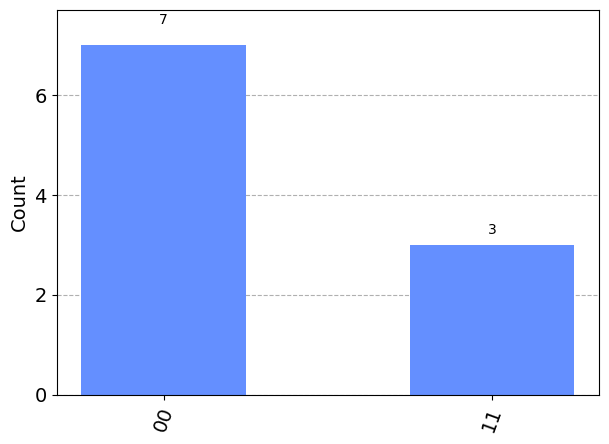

In [8]:
results = task.result()
plot_histogram(results.get_counts())

Each single shot measurements are also retrievable.

In [9]:
results.get_memory()

['00', '00', '00', '00', '00', '11', '00', '11', '00', '11']

More complex circuits on devices can be submitted to the Braket devices and simulators. Behind the scenes, the qiskit transpiler will adapt the circuits such that they are executable on all devices. In the following, we will focus on running circuit in the IonQ Aria-1 device. 

We will start with generating random circuit and printing it out.

In [10]:
qiskit_random_circuit = random_circuit(4, 5, seed=42)
qiskit_random_circuit.draw(fold=-1)

┌───────────────────────┐    ┌───┐                  ┌────────────┐     
q_0: ─────────────────────┤0                      ├────┤ H ├───────■──────■───┤ Rz(2.9325) ├─────
     ┌───────────────────┐│                       │    └─┬─┘     ┌─┴──┐   │   ├────────────┤┌───┐
q_1: ┤ R(4.3817,0.59173) ├┤                       ├──────■───────┤ Sx ├───┼───┤ Ry(2.2276) ├┤ X ├
     └───┬───────────┬───┘│  (XX+YY)(6.13,4.7824) │              ├───┬┘ ┌─┴─┐ └────────────┘└─┬─┘
q_2: ────┤ Ry(4.939) ├────┤                       ├──────■───────┤ H ├──┤ Y ├─────────────────■──
         └───────────┘    │                       │┌─────┴──────┐└─┬─┘ ┌┴───┴┐                │  
q_3: ─────────────────────┤1                      ├┤ Ry(4.0455) ├──■───┤ Tdg ├────────────────■──
                          └───────────────────────┘└────────────┘      └─────┘

Each device has a set of supported operations which are accessible via the backend.

In [ ]:
aria_supported_gates = Aria_1.get_gateset()
print(aria_supported_gates)

{'tdg', 'rx', 'h', 's', 'x', 'y', 'sdg', 'ry', 'rxx', 'cx', 'rzz', 'sxdg', 'z', 'sx', 'ryy', 'rz', 't', 'swap'}


In [12]:
braket_random_circuit = to_braket(
    qiskit_random_circuit, basis_gates=aria_supported_gates
)
print(braket_random_circuit)

T  : |    0    |1|   2    | 3 |    4    |5|    6    |    7    |   8    |   9    |10|   11    |12|13|14|   15   |16|   17    |18|   19   |20|    21    |   22   |23|24|25|26|27|28|29|30|31|32|
                                                                                                                                                                                              
q0 : -Rz(4.78)--S------------X-Ry(-3.07)-X-Si--------Rz(-4.78)-S--------H--------T--X---------Ti-H--Si-Rz(0.79)-C------------C-----------------------C-Rz(2.93)-------------------------------
                             |           |                                          |                           |            |                       |                                        
q1 : -Rz(0.98)--V-Rz(7.52)-V-|-Rz(8.45)--|------------------------------------------C---------H-----------------X--Rz(-0.79)-X--Rz(0.79)-H--Ry(2.23)-|-H--------X--Ti-X--T--X--Ti-X--T--H-----
                             |           |   

/Users/caw/Documents/GitHub/qiskit-braket-provider/qiskit_braket_provider/providers/adapter.py:475: UserWarning: Device does not support global phase; global phase of 5.105088062083414 will not be included in Braket circuit
  warnings.warn(


We printed the Braket Circuit object that will be used to create the quantum task on the Aria-1 device. To submit the task, you do not have to create a Braket circuit, this is done internal when you submit the Qiskit circuit to the Backend.

In [13]:
aria_task = Aria_1.run(qiskit_random_circuit, shots=10)

If you do not want to wait for the task completion and return to it later, you can use `retrieve_job` method on device to get job object. For this, you will need to know the job_id (which is the task ARN that identifies the task in the AWS cloud).

In [14]:
task_arn = aria_task.job_id()
retrieved_task = Aria_1.retrieve_job(task_id=task_arn)

From the task, you can check its status: 

In [15]:
retrieved_task.status()

<JobStatus.QUEUED: 'job is queued'>

and get the results as done previously: 

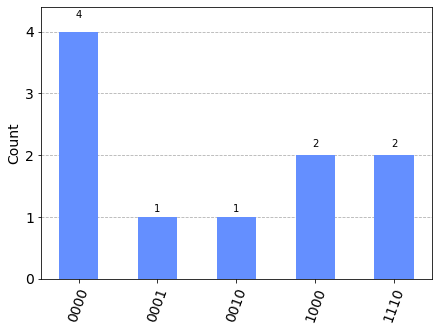

In [18]:
random_circuit_results = retrieved_task.result()
plot_histogram(random_circuit_results.get_counts())

In [19]:
print("Quantum Task Summary")
print(t.quantum_tasks_statistics())
print(
    "Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing "
    "unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated "
    "charges do not factor in any discounts or credits, and you may experience additional charges "
    "based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2)."
)
print(
    f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD"
)

Quantum Task Summary
{'arn:aws:braket:us-east-1::device/qpu/ionq/Aria-1': {'shots': 10, 'tasks': {'COMPLETED': 1}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.600 USD
